# Basic singlet lens tutorial

Borrowing the "Lens Makers Formula" from here, and simplifying it...

http://hyperphysics.phy-astr.gsu.edu/hbase/geoopt/lenmak.html

For a lens in air,

$1/f = (n - 1)(1/R_1 - 1/R_2)$

Moreover, if it's a plano-convex lens, $1/R_2 = 0$, so that

$f = R_1 / (n - 1)$

For typical glasses, $n \approx 1.5$, so $f \approx 2 R_1$

In [23]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# import time

import opticsRayTrace.rayTraceTools as rtt
import opticsRayTrace.drawing as rtd
import opticsRayTrace.optimize as rto

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The "surface list" is where I specify my design. I use the **dict** structure for 
representing each surface because it's flexible, and easy to add things. A surprising
feature of Python is that manipulating **dict** objects does not impose a huge
speed penalty on programs.

There are always dummy surfaces at the beginning
and end of the system. These represent the object and image planes. For now they
are arbitrary planes in space. The object distance of 10 mm is just to make the
incoming ray bundle visible in drawings, and the image distance is equal to my
approximate focal length, again so the drawings make sense.

Always start with something that can be drawn, so you can see if it makes sense.

In [24]:
surface_list = [
    {
        'surf': 'dummy',
        'dist': 10,
    },
    {
        'surf': 'conic',
        'R': 25,
        'dist': 5,
        'material': 'N-BK7',
        'draw_radius': 12.5,
    },
    {
        'surf': 'conic',
        'curvature': 0,
        'dist': 50,
        'draw_radius': 12.5,
    },
    {
        'surf': 'dummy',
    }
]

The surface list is laid out in a traditional fashion, where each surface specifies the
distance to the next surface. My program turns the surface list into a "geometry," which
includes information on the position and orientation of each surface in a "global"
coordinate system.

After creating the geometry, I'll show just the convex surface, so you can see that a lot
of parameters have been added. Most of these are defaults added by my Python package.

In [25]:
geometry = rtt.build_geometry(surface_list)

# Look at just one element of the geometry

geometry[1]

{'surf': 'conic',
 'R': 25,
 'dist': 5,
 'material': 'N-BK7',
 'draw_radius': 12.5,
 'draw': True,
 'draw_dx': 0,
 'draw_dy': 0,
 'mirror': False,
 'c': 0.04,
 'k': 0,
 'color': '#ff7f0e',
 'glass_coeffs': [1.03961212,
  0.00600069867,
  0.231792344,
  0.0200179144,
  1.01046945,
  103.560653],
 'origin': array([ 0,  0, 10]),
 'x_axis': array([1, 0, 0]),
 'y_axis': array([0, 1, 0]),
 'z_axis': array([0, 0, 1])}

With just the geometry and no rays, it's possible to look at a picture of the system.


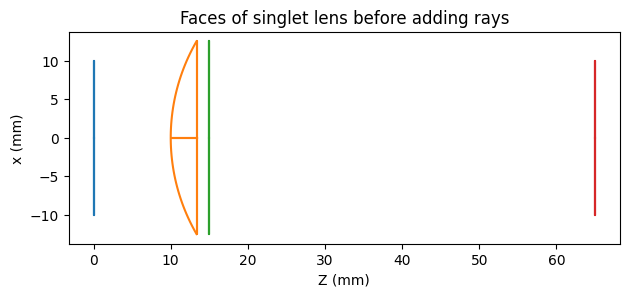

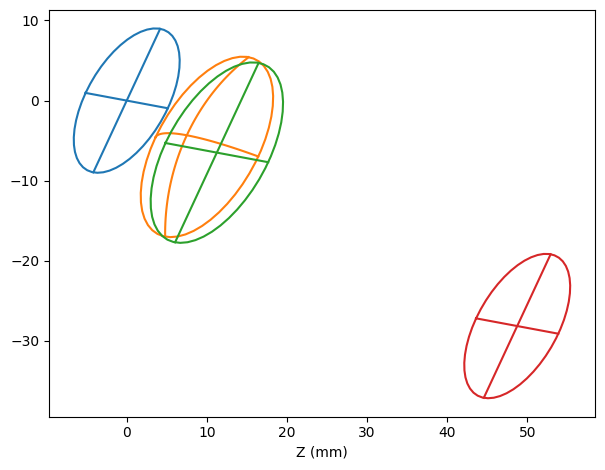

In [26]:
axd = rtd.new_plot(axes = ["x"])
rtd.plot_faces(axd, geometry)
plt.title('Faces of singlet lens before adding rays')
plt.show()

axd = rtd.new_plot(axes = ["3d"])
rtd.plot_faces(axd, geometry)
plt.show()

A circular bundle of parallel rays is such a common starting point for ray tracing
analyses, that I've created a library function for building one.

After creating my ray bundle, I'll plot the points where the rays pass through the
object aperture, to ilustrate what "rings" are. The rays are arranged in concentric
rings, with the number of rays proportional to the radius, resulting in a roughly
uniform filling of the aperture. This is a familiar feature of most ray tracing
softare.

In [27]:
help(rtt.ray_table_fields_rings)

Help on function ray_table_fields_rings in module opticsRayTrace.rayTraceTools:

ray_table_fields_rings(geometry, max_field_degrees, number_of_fields, pupil_diameter_mm, number_of_rings, wavls)
    Create a basic circular ray bundle. This is the most common type of ray bundle used for
    general purpose ray tracing, so I created a function for it. 
    
    geometry = geometry object representing your design
    max_field_degrees = maximum field angle. Fields start from 0 to this angle.
    number_of_fields = number of fields represented, which can be 1
    pupil_diameter_mm = diameter of circular ray bundle in mm
    number_of_rings = number of circular "rings" of rays
    wavls = list of wavelengths, in mm, e.g., 633 nm is 0.000633 mm
    
    Returns: Initialized ray table



The ray table is a pure Numpy array, to speed up ray tracing. It's a complicated structure,
because rays possess information beyond the basic "point and vector" representation. This
is good enough for "internal" use of the ray table by my program, but makes it somewhat
cryptic. For users, the main reason to be concerned about the ray table is to write your
own analysis functions.

In [28]:
ray_table = rtt.ray_table_fields_rings(geometry, 0, 1, 20, 3, [0.000633])
print(rtt.help_ray_table)
ray_table


    Help for ray table. The table is structured like this:

    ray_table[surf #, ray #, type #, data]

    type = 0
        data = intersection point of ray in space
    type = 1
        data = direction vector of ray
    type = 2
        data = [refractive index, wavelength, <reserved>]
    type = 3
        data = [field #, pupil #, wavelength #]
    


array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
         [ 1.00000000e+00,  6.33000000e-04,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  5.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
         [ 1.00000000e+00,  6.33000000e-04,  0.00000000e+00],
         [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00]],

        [[ 4.33012702e+00,  2.50000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
         [ 1.00000000e+00,  6.33000000e-04,  0.00000000e+00],
         [ 0.00000000e+00,  2.00000000e+00,  0.00000000e+00]],

        [[ 4.33012702e+00, -2.50000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
         [ 1.00000000e+00,  6.33000000e-04,  0.00000000e+00],
         [ 0.00000000e+00,  3.00000000e+00,  0.00000000e+00]],



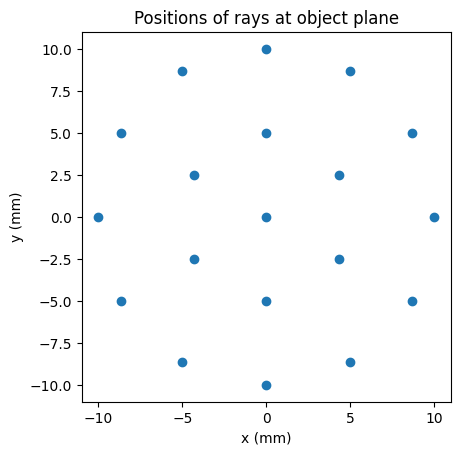

In [29]:
pupil_points = ray_table[0, :, 0, :]
plt.scatter(pupil_points[:, 0], pupil_points[:, 1])
plt.gca().set_aspect('equal')
plt.title('Positions of rays at object plane')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

Trace the path of each ray through the system. This function modifies the elements
of the ray table in place, so it doesn't return anything.

*This is the ray tracing step*.

In [30]:
rtt.trace_rays(ray_table, geometry)

Following ray tracing, the ray table contains the path of each ray through the system, and the
geometry is unchanged. Now we're ready for analysis. No surprise: The most common form of
analysis is looking at pictures.

My drawing routines are crude for now. There are good 3d drawing packages for Python, but I
haven't gotten around to trying any of them yet. Instead, my built-in drawing routines project
the surfaces and rays onto a plane, and draw the resulting graph in a 2-d graphing package.

For now the colors are chosen arbitrarily by Matplotlib.

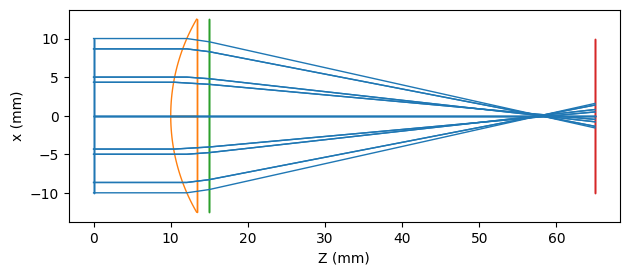

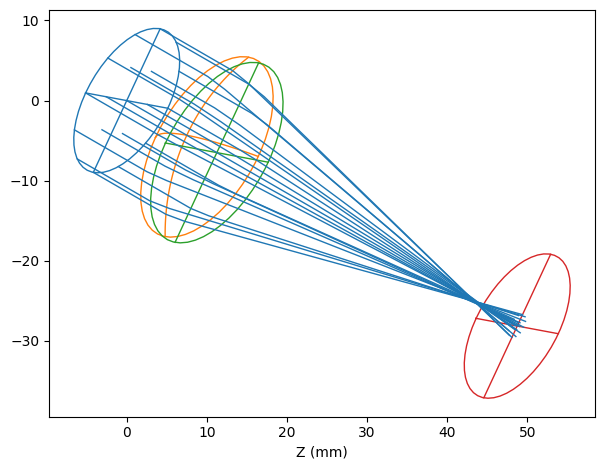

In [31]:
axd = rtd.new_plot(axes = ["x"])
rtd.plot_faces(axd, geometry, linewidth = 1)
rtd.plot_rays(axd, geometry, ray_table, linewidth = 1, color_by = "field")
plt.show()

axd = rtd.new_plot(axes = ["3d"])
rtd.plot_faces(axd, geometry, linewidth = 1)
rtd.plot_rays(axd, geometry, ray_table, linewidth = 1, color_by = "field")
plt.show()

Now we're ready for a totally basic analysis, just to illustrate what it looks like. We're
going to generate the RMS spot size. I've been trying to avoid showing a lot of Python,
but I'm going to show some here *because you will be writing Python code for any nontrivial
use of my package*. This function will also be built into the package.

Because this design is axially symmetric, we care about a single number for the quality of
focus, the RMS distance from the optical axis.

In [32]:

def rms_by_field_xy(ray_table, index = -1):
    '''
    Compute RMS spot size as a function of field number for X ad Y

    index = the surface number of interest, or -1 for the last surface

    Returns: rms[field_number, axis]
    '''
    
    rayx = ray_table[index, :, 0, 0]
    rayy = ray_table[index, :, 0, 1]
    rayfields = ray_table[-1, :, 3, 0].astype(int)
    return np.array([[np.std(rayx[rayfields == f]), np.std(rayy[rayfields == f])] 
                     for f in np.arange(np.max(rayfields) + 1)])

def rms_by_field_radial(ray_table, index = -1):
    '''
    Computes RMS spot size as a function of field number for R

    Returns: rms[field_number]
    '''

    rms_xy = rms_by_field_xy(ray_table, index)
    return np.sqrt(np.average(rms_xy**2, axis = 1))

rms_by_field_radial(ray_table)

array([0.91961736])

# New tutorial: Basic optimization, to find the best focus

This is going to be a digression into Python. Writing some Python code to optimize for
the best focus got me thinking about creating some general purpose functions to help
with optimization, which I'm going to develop here.

I'm going to take the basic surface list and add a "variables" term to one of the
surfaces. This is going to let my program automatically identify which items are
allowed to vary during optimization, and for now, it's just going to be the final
focus distance.

In [33]:
design_2 = [
    {
        'surf': 'dummy',
        'dist': 10,
    },
    {
        'surf': 'conic',
        'R': 25,
        'dist': 5,
        'material': 'N-BK7',
        'draw_radius': 12.5,
    },
    {
        'surf': 'conic',
        'curvature': 0,
        'dist': 50,
        'draw_radius': 12.5,
        'variables': ['dist']
    },
    {
        'surf': 'dummy',
    }
]

ray_table_2 = rtt.ray_table_fields_rings(geometry, 0, 1, 20, 3, [0.000633])

I'm going to write and test some general purpose functions for working with the "variables"
in the design. The idea is that the minimize() function needs an array of parameters, but
those parameters may be arbitrary elements of the surface list, so we need a way to go back
and forth between the two.

In [34]:
def get_variable_list(surface_list):
    '''
    Search the surface list for variables, and create a variable list.

    returns [{'surf': surface_number, 'var': parameter_name, 'val': value}]
    '''
    result = []
    for i in range(len(surface_list)):
        surf = surface_list[i]
        if 'variables' in surf.keys():
            for var in surf['variables']:
                result.append({'surf': i, 'var': var, 'val': surf[var]})
    return result

variable_list = get_variable_list(design_2)
variable_list


[{'surf': 2, 'var': 'dist', 'val': 50}]

In [35]:
def get_values(variable_list):
    '''
    Return the values of variables in the design, as a straight Numpy array
    '''
    
    return np.array([d['val'] for d in variable_list])

params = get_values(variable_list)
params


array([50])

In [36]:
def update_values(surface_list, params):
    '''
    Take a straight numpy array of values and insert them back into the surface
    list. This assumes the surface list has the same structure as the parameter
    list, i.e., you haven't done anything really funky with the surface list.
    '''
    
    variable_list = get_variable_list(surface_list)
    for i in range(len(variable_list)):
        var = variable_list[i]
        surf = surface_list[var['surf']]
        surf[var['var']] = params[i]

update_values(design_2, [55])
design_2

[{'surf': 'dummy', 'dist': 10},
 {'surf': 'conic',
  'R': 25,
  'dist': 5,
  'material': 'N-BK7',
  'draw_radius': 12.5},
 {'surf': 'conic',
  'curvature': 0,
  'dist': 55,
  'draw_radius': 12.5,
  'variables': ['dist']},
 {'surf': 'dummy'}]

Now it's time to get down to the business of optimization. The functions I've defined above will
end up in my Python library, so you won't have to look at them. Optimization in optics design
typically involves finding the set of parameters that minimizes a so called "merit" function. This
is a misnomer, because you want less merit. It's called a "loss" function in machine learning.

The merit function is supposed to analyze what happens when the *design* has changed. For this
reason, each computation of the merit function requires going through the entire process of
building the geometry and tracing rays. You don't have to rebuild the starting ray table, because
**trace_rays()** only needs the first column of the table, which never changes.

In [37]:
def merit_prepare(params, ray_table, surface_list):
    '''
    These are the preliminaries that a merit function always needs before
    performing an analysis of the ray table.

    1. Stuff the parameter values back into the surface list
    2. New parameter values require computing a new geometry
    3. Finally, trace rays through the new geometry

    The ray table and surface list are modified in place.
    '''

    update_values(surface_list, params)
    geometry = rtt.build_geometry(surface_list)
    rtt.trace_rays(ray_table, geometry)

def merit(params, ray_table, surface_list):
    merit_prepare(params, ray_table, surface_list)
    rmsa = rms_by_field_radial(ray_table)
    merit = np.sqrt(np.average(rmsa**2))

    return merit

This aside shows the value of the merit function as the parameter value changes,
so we can see that it does go through a minimum.

Text(0, 0.5, 'Merit function')

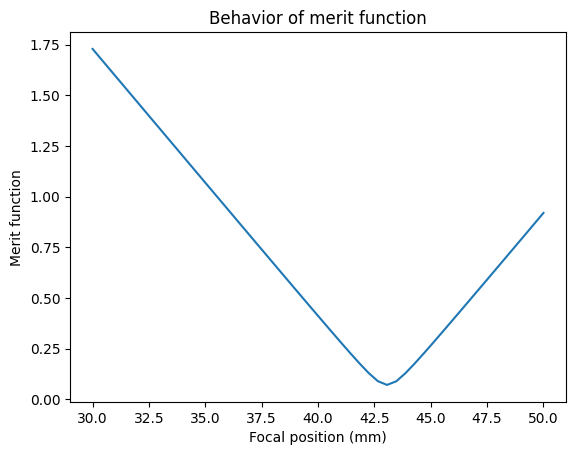

In [38]:
za = np.linspace(30, 50)
ma = []
for z in za:
    ma.append(merit([z], ray_table_2, design_2))
plt.plot(za, ma)
plt.title('Behavior of merit function')
plt.xlabel('Focal position (mm)')
plt.ylabel('Merit function')

Now we're ready to optimize. I've arranged everything so I can use a built-in numeric function
from Scipy, 

In [39]:
result = minimize(merit, [50], (ray_table_2, design_2))
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.07055392331725917
        x: [ 4.307e+01]
      nit: 3
      jac: [-4.275e-07]
 hess_inv: [[ 4.040e+00]]
     nfev: 18
     njev: 9

In [40]:
update_values(design_2, result['x'])
geometry_2 = rtt.build_geometry(design_2)
rtt.trace_rays(ray_table_2, geometry_2)

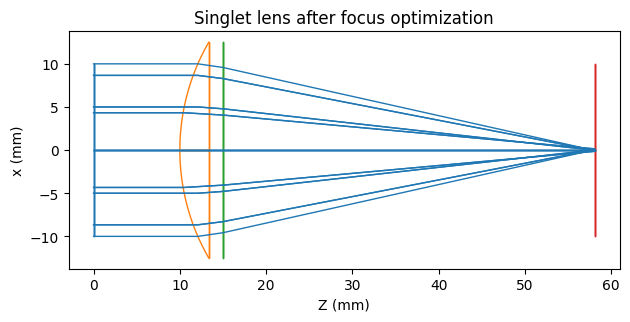

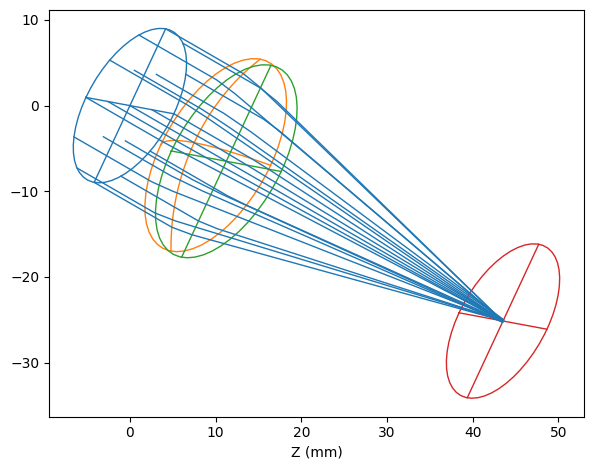

In [41]:
axd = rtd.new_plot(axes = ["x"])
rtd.plot_faces(axd, geometry_2, linewidth = 1)
rtd.plot_rays(axd, geometry_2, ray_table_2, linewidth = 1, color_by = "field")
plt.title('Singlet lens after focus optimization')
plt.show()

axd = rtd.new_plot(axes = ["3d"])
rtd.plot_faces(axd, geometry_2, linewidth = 1)
rtd.plot_rays(axd, geometry_2, ray_table_2, linewidth = 1, color_by = "field")
plt.show()

# Another tutorial: Computing the focal length

My "rule of lens" is that a focused lens converts field angles to image positions, and vice versa. Thus you can
find the focal length of an arbitrary lens by tracing two angles, and finding the change in image position.
The ratio of position to angle is the focal length. I will choose a small test angle of 0.01 radians.

In [42]:
test_angle = 0.01 # in radians
test_rays = rtt.ray_table_fields_rings(geometry, test_angle*180/np.pi, 2, 20, 3, [0.000633])

In [43]:
geometry_3 = rtt.build_geometry(design_2)
rtt.trace_rays(test_rays, geometry_3)

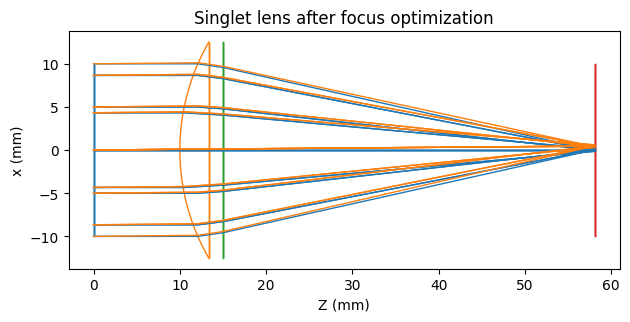

In [44]:
axd = rtd.new_plot(axes = ["x"])
rtd.plot_faces(axd, geometry_3, linewidth = 1)
rtd.plot_rays(axd, geometry_3, test_rays, linewidth = 1, color_by = "field")
plt.title('Singlet lens after focus optimization')
plt.show()

In [127]:
def average_by_field_xy(ray_table, index = -1):
    '''
    Compute RMS spot size as a function of field number for X ad Y

    index = the surface number of interest, or -1 for the last surface

    Returns: rms[field_number, axis]
    '''
    
    rayx = ray_table[index, :, 0, 0]
    rayy = ray_table[index, :, 0, 1]
    rayfields = ray_table[-1, :, 3, 0].astype(int)
    return np.array([[np.average(rayx[rayfields == f]), np.average(rayy[rayfields == f])] 
                     for f in np.arange(np.max(rayfields) + 1)])

spot_positions = average_by_field_xy(test_rays)
spot_positions

array([[1.63611814e-16, 1.63977019e-16],
       [4.55635495e-01, 2.37383213e-17]])

In [128]:
test_position = spot_positions[1, 0]
test_position

0.455635495349682

In [129]:
focal_length = test_position/test_angle
focal_length

45.5635495349682